In [1]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
from CoolProp.HumidAirProp import HAPropsSI
from CoolProp.CoolProp import PropsSI
import pandas as pd

def exergy_water(T, P, T_0, P_0, twophase):
        # This function calculates the flow exergy free energy of a liquid water stream relative to a reference state
        # T: Temperature in K
        # P: Partial pressure of Water in Pa
        # T_0: Dead state temperature
        # P_0: Dead state pressure
        h_0 = PropsSI('H','T', T_0, 'P', P_0, 'Water')
        s_0 = PropsSI('S','T', T_0, 'P', P_0, 'Water')
        if twophase == 0:
                h = PropsSI('H','T', T, 'P', P, 'Water') - h_0
                s = PropsSI('S','T', T, 'P', P, 'Water') - s_0
        else:
                h = PropsSI('H','T',T,'Q',1,'Water') - h_0
                s = PropsSI('S','T', T, 'Q',1, 'Water') - s_0

        e_f = h - (T_0 * s)
        return e_f/1000

def get_pv(T,rh):
        # this function finds the vapor at the given temperature, using the clausius clapyeron relationship
        # the reference saturation point is 300K, 5.3251 kPa
        # T = Temperature (K)
        # rh = relative humidity (%)
        T_ref = 307.15
        P_ref = 5325.1
        T_avg = 0.5*(T_ref + T)   # evaluate hfg at the average temperature
        R = 461.52                # mass-based gas constant of water vapor - J/kgK
        T_inv = 1/T
        T_ref_inv = 1/T_ref
        logP_rat = 0
        for T_eval in np.linspace(T_inv,T_ref_inv,100):
                hfg = PropsSI('H','T',1/T_eval,'Q',1,'Water') - PropsSI('H','T',1/T_eval,'Q',0,'Water') # J/kg
                #hfg = 2549854.1010947493
                logP_rat += -(hfg/R)*(T_eval - T_ref_inv)*abs(T_inv-T_ref_inv)/99
        p_sat = P_ref*np.exp(logP_rat)
        pv = rh*p_sat
        return pv
get_pv_vec = np.vectorize(get_pv)


def get_pv2(T,rh): 
    """
    T: in K
    rh: [0,1]
    p_sat is calculated with the buck equation.
    pv is returned in Pa
    """
    T_c = T-273.15
    p_sat_kpa = 0.61121*np.exp((18.678 - T_c/234.5)*(T_c/(T_c + 257.14)))
    pv = (1000*p_sat_kpa)*rh
    return pv

In [2]:
get_pv2(303.15,1)

4245.12571625229

In [4]:
#T = np.linspace(300,300)
#P = np.linspace(10100, 10100)

#T_0 = np.linspace(300,300)
#P_0 = get_pv(T_0,rh = np.linspace(1,1))
T = 300
P = 10100

T_0 = 300

r = 0.3
T_amb = T_0


LW = []
rec = [0.01, 0.05, 0.1]
min_LW = []
for rh_amb in np.linspace(0.01,0.99,100):
        P_0 = get_pv2(T_0,rh_amb)
        for r in rec:
                pv_feed = get_pv2(T_amb,rh_amb)
                pv_brine = pv_feed
                pv_sat = get_pv2(T_amb, rh =1)# np.linspace(1,1))

                feed_exergy = exergy_water(T_amb, pv_feed, T_0, P_0,1)
                brine_exergy = exergy_water(T_amb, pv_brine, T_0, P_0,1)
                saturated_exergy = exergy_water(T_amb, pv_sat, T_0, P_0,0)

                #perm_exergy = exergy_water(T, P, T_0, P_0, 1)
                sep = saturated_exergy + (1-r)*brine_exergy/r - feed_exergy/r
                LW.append(sep)

        p = np.polyfit(rec,LW,2)
        LW = []
        min_LW.append(np.polyval(p,0))

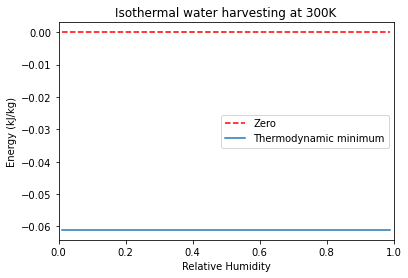

In [5]:
rh_amb = np.linspace(0.01,0.99,100)
#print(min_LW)
zero = np.zeros(100)
fig, ax = plt.subplots()
ax.plot(rh_amb, zero,'r--', label = 'Zero')
ax.set_title('Isothermal water harvesting at 300K')
ax.set_ylabel('Energy (kJ/kg)')
ax.set_xlabel('Relative Humidity')
ax.set_xlim([0,1])
ax.plot(rh_amb, min_LW, label = 'Thermodynamic minimum')
ax.legend()

#fig1, ax1 = plt.subplots()
#ax1.set_title('Isothermal water harvesting at 300K')
#ax1.plot(rh_amb, np.log(min_LW))
#ax1.set_ylabel('Log Least Work (kJ/kg)')
#ax1.set_xlabel('Relative Humidity')

plt.show()

In [6]:
#T = np.linspace(300,300)
#P = np.linspace(10100, 10100)

#T_0 = np.linspace(300,300)
#P_0 = get_pv(T_0,rh = np.linspace(1,1))
T = 300
P = 10100

T_0 = 300

r = 0.3
T_amb = T_0


LW = []
rec = [0.1, 0.05, 0.025]
min_LW = []
for rh_amb in np.linspace(0.01,0.99,100):
        P_0 = get_pv2(T_0,rh_amb)
        for r in rec:
                pv_feed = get_pv2(T_amb,rh_amb)
                pv_brine = pv_feed#*(1-r)
                pv_sat = get_pv2(T_amb, rh =1)# np.linspace(1,1))

                feed_exergy = exergy_water(T_0, pv_feed, T_0, P_0,0)
                brine_exergy = exergy_water(T_0, pv_brine, T_0, P_0,0)
                saturated_exergy = exergy_water(T, pv_sat, T_0, P_0,1)

                #perm_exergy = exergy_water(T, P, T_0, P_0, 1)
                sep = saturated_exergy + (1-r)*brine_exergy/r - feed_exergy/r
                LW.append(sep)
        
        p = np.polyfit(rec,LW,2)
        LW = []
        min_LW.append(round(np.polyval(p,0),2))

In [53]:
def LW_single_comp(T_0,rh, T = 300):
    P_0 = get_pv2(T_0,rh)
    rec = [0.1, 0.05, 0.025]
    LW = []
    for r in rec:
        pv_feed = get_pv2(T_0, rh)
        pv_brine = pv_feed#*(1-r)
        pv_sat = get_pv2(T_0, rh = 1)

        feed_exergy = exergy_water(T_0, pv_feed, T_0, P_0,0)
        brine_exergy = exergy_water(T_0, pv_brine, T_0, P_0,0)
        saturated_exergy = exergy_water(T_0, pv_sat, T_0, P_0,0)
        #print(feed_exergy, brine_exergy, saturated_exergy)
        sep = saturated_exergy + (1-r)*brine_exergy/r - feed_exergy/r
        LW.append(sep)
    p = np.polyfit(rec,LW,2)
    sep = np.polyval(p,0)
    
    permeate_exergy = exergy_water(T, pv_sat, T_0, P_0,0)
    #print(permeate_exergy- saturated_exergy)
    heat = (1-T_0/T)*(permeate_exergy - saturated_exergy)
    if T_0>T:
        heat = heat*-1
    #print(sep, heat, (1-T/T_0))
    return sep+heat

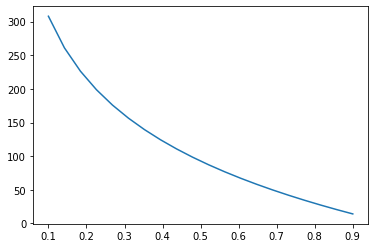

In [55]:
temp = np.linspace(275,340,50)
humd = np.linspace(0.1, 0.9, 20)
#press = get_pv2(300,1)
#feed_press = get_pv2(300, 1)

#f_exergy = exergy_water(300, feed_press, temp, press, 1)

LW_test2 = np.zeros(20)
for i, rh in enumerate(humd):
    LW_test2[i] = LW_single_comp(290, rh= rh)

fig4,ax4 = plt.subplots()
#print(LW_test2)
dT = temp - 300
ax4.plot(humd, LW_test2);

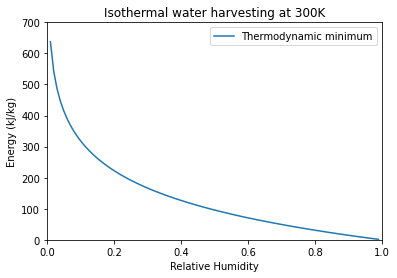

In [56]:
rh_amb = np.linspace(0.01,0.99,100)
#print(min_LW)
zero = np.zeros(100)
fig, ax = plt.subplots()
#ax.plot(rh_amb, zero,'r--', label = 'Zero')
ax.set_title('Isothermal water harvesting at 300K')
ax.set_ylabel('Energy (kJ/kg)')
ax.set_xlabel('Relative Humidity')
ax.set_xlim([0,1])
ax.set_ylim([0,700])
ax.plot(rh_amb, min_LW, label = 'Thermodynamic minimum')
ax.legend()

#fig1, ax1 = plt.subplots()
#ax1.set_title('Isothermal water harvesting at 300K')
#ax1.plot(rh_amb, np.log(min_LW))
#ax1.set_ylabel('Log Least Work (kJ/kg)')
#ax1.set_xlabel('Relative Humidity')

plt.show()

In [63]:
def gibbs_HA(T,P,rh, T_0):
    h = HAPropsSI('Hha','T', T, 'P', P, 'R',rh)
    s = HAPropsSI('Sha','T', T, 'P', P, 'R',rh)
    g = h-T_0*s
    return g

def gibbs_satv(T, T_0):
    h = PropsSI('H','T', T, 'Q',0,'Water')
    s = PropsSI('S','T', T, 'Q',0,'Water')
    g = h-T_0*s
    return g

def calcLW(T,P,rh,r = 0.1):
    W = HAPropsSI('W', 'T', T, 'P', P, 'R', rh)
    dw = []
    sep = []
    for i in np.arange(0, 3, 1):
        dw.append(r * W)
        W_reject = W * (1 - r)
        rh_reject = HAPropsSI('R', 'T', T, 'P', P, 'W', W_reject)
        G_p = gibbs_satv(T,T)
        G_f = gibbs_HA(T, P, rh,T)
        G_b = gibbs_HA(T, P, rh_reject,T)
        sep.append((G_p + G_b * (1 - dw[i]) / dw[i] - G_f / dw[i]) / 1000)
        r = r / 2
        #print(r, dw[i], sep[i])
    #print('Gp, g_f, g_b =  ',G_p, G_f, G_b)
    #print('dw = ',dw[2])
    z = np.polyfit(dw, sep, 2)
    f = np.poly1d(z)
    min_sep = f(0)
    #print('LW= ', min_sep)
    return min_sep
T = 300
LW_CP = []
for rh_amb in np.linspace(0.01,0.95,100):
    temp_lw_calc = calcLW(T,P,rh = rh_amb)
    LW_CP.append(round(temp_lw_calc))

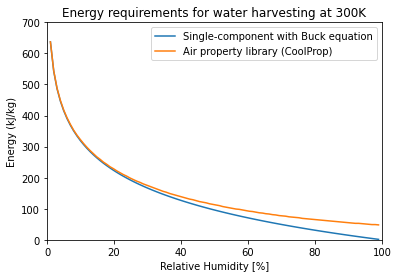

In [64]:
rh_amb = np.linspace(0.01,0.99,100)
#print(min_LW)
zero = np.zeros(100)
fig, ax = plt.subplots()
#ax.plot(rh_amb, zero,'r--', label = 'Zero')
ax.set_title('Energy requirements for water harvesting at ' + str(T) + 'K')
ax.set_ylabel('Energy (kJ/kg)')
ax.set_xlabel('Relative Humidity [%]')
ax.set_xlim([0,100])
ax.set_ylim([0,700])
ax.plot(rh_amb*100, min_LW, label = 'Single-component with Buck equation')
ax.plot(rh_amb*100, LW_CP, label = 'Air property library (CoolProp)')
ax.legend();
fig.savefig('CC_prop_val.svg')

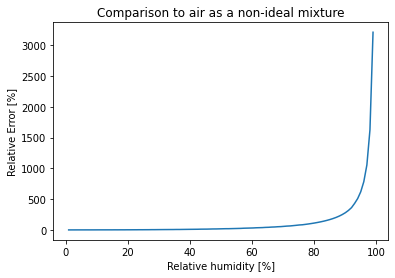

In [65]:
error = abs(np.array(LW_CP) - np.array(min_LW))
error = 100*np.divide(error, np.array(min_LW))
fig1, ax1 = plt.subplots()
ax1.set_title('Comparison to air as a non-ideal mixture')
ax1.set_ylabel('Relative Error [%]')
ax1.set_xlabel('Relative humidity [%]')
ax1.plot(rh_amb*100, error);
fig1.savefig('CC_prop_error.svg')

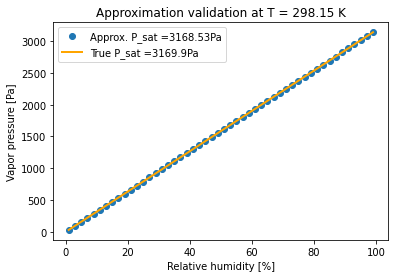

In [66]:
rh_amb = np.linspace(0.01, 0.99, 50)
pv_test = get_pv2(298.15, rh_amb)
pv_sat_test = get_pv2(298.15,1)
pv_true = rh_amb*3169.9
fig2, ax2 = plt.subplots()
ax2.set_title('Approximation validation at T = 298.15 K')
ax2.set_ylabel('Vapor pressure [Pa]')
ax2.set_xlabel('Relative humidity [%]')

ax2.plot(100*rh_amb, pv_test, 'o',lw = 1, label = 'Approx. P_sat =' + str(round(pv_sat_test,2)) + 'Pa')
ax2.plot(100*rh_amb, pv_true, 'orange',lw = 2, label = 'True P_sat =' + str(3169.9) + 'Pa')
ax2.legend();
fig2.savefig('approx_val.svg')

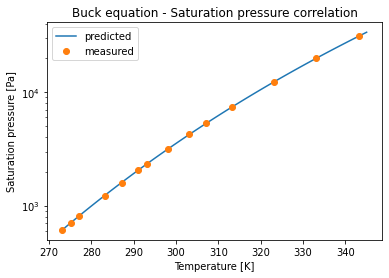

In [67]:
T_test2 = np.linspace(273.2, 345, 100) 
psat_test2 = get_pv2(T_test2, 1)
T_valid = 273.15 + np.array([0.01, 2, 4, 10, 14, 18, 20, 25, 30, 34, 40, 50, 60, 70])
psat_valid = 1000*np.array([0.61165, 0.70599, 0.81355, 1.2282, 1.5990, 2.0647, 2.3393, 3.1699, 4.2470,5.3251, 7.3849, 12.352,19.946, 31.201])
fig3, ax3 = plt.subplots()
ax3.set_title('Buck equation - Saturation pressure correlation')
ax3.set_xlabel('Temperature [K]')
ax3.set_ylabel('Saturation pressure [Pa]')
ax3.set_yscale('log')
ax3.plot(T_test2, psat_test2, label = 'predicted')
ax3.plot(T_valid, psat_valid, 'o', label = 'measured')
ax3.legend();
fig3.savefig('CC_valid_temp.svg')

In [139]:
humd = np.linspace(0.01,0.99,100)
temp = np.linspace(285,315,100)
LW_CP = np.zeros((len(humd), len(temp)))
LW_SC = np.zeros((len(humd), len(temp)))


for i,rh in enumerate(humd):
    for j,T in enumerate(temp):
        singlecomp_lw_calc = LW_single_comp(T, rh= rh)
        coolprop_lw_calc = calcLW(T,P,rh)
        LW_SC[i][j] = round(singlecomp_lw_calc,2)
        LW_CP[i][j] = round(coolprop_lw_calc,2)

In [140]:
mul_fac = np.divide(LW_CP, LW_SC)
residual = LW_CP - LW_SC

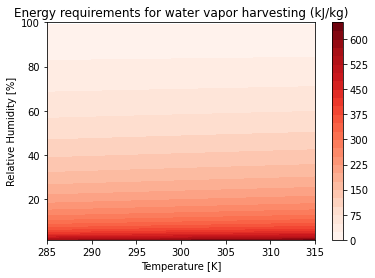

In [146]:
## Plot single component 
fig, ax = plt.subplots()
ax.set_title('Energy requirements for water vapor harvesting (kJ/kg)')
ax.set_ylabel('Relative Humidity [%]')
ax.set_xlabel('Temperature [K]')
ax.set_xlim([285,315])
ax.set_ylim([1.5,100])
length = np.linspace(0, 650, 27)
cs = ax.contourf(temp, 100*humd, LW_SC, length, cmap="Reds")
cbar = fig.colorbar(cs)
plt.show()
fig.savefig('energy_vapor_contour.svg')

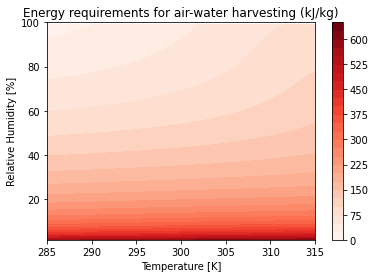

In [156]:
## Plot air mixture 
fig1, ax1 = plt.subplots()
ax1.set_title('Energy requirements for air-water harvesting (kJ/kg)')
ax1.set_ylabel('Relative Humidity [%]')
ax1.set_xlabel('Temperature [K]')
ax1.set_xlim([285,315])
ax1.set_ylim([1.5,100])
length = np.linspace(0, 650, 27)
cs = ax1.contourf(temp, 100*humd, LW_CP, length, cmap="Reds")
cbar = fig1.colorbar(cs)
plt.show()
fig1.savefig('energy_air_contour.svg')

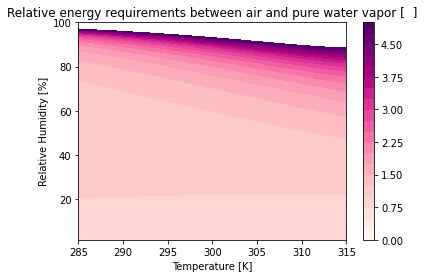

In [149]:
# plot multiplicative factor
## Plot single component 
fig2, ax2 = plt.subplots()
ax2.set_title('Relative energy requirements between air and pure water vapor [  ]')
ax2.set_ylabel('Relative Humidity [%]')
ax2.set_xlabel('Temperature [K]')
ax2.set_xlim([285,315])
ax2.set_ylim([1.5,100])
length = np.linspace(0, 5, 21)
cs = ax2.contourf(temp, 100*humd, mul_fac, length, cmap="RdPu")
cbar = fig2.colorbar(cs)
plt.show()
fig2.savefig('air_water_vaporcomp.svg')

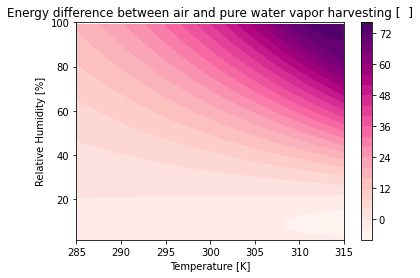

In [154]:
# plot residual/ error 

fig2, ax2 = plt.subplots()
ax2.set_title('Energy difference between air and pure water vapor harvesting [  ]')
ax2.set_ylabel('Relative Humidity [%]')
ax2.set_xlabel('Temperature [K]')
ax2.set_xlim([285,315])
ax2.set_ylim([1.5,100])
#length = np.linspace(0, 5, 21
cs = ax2.contourf(temp, 100*humd, residual, 20, cmap="RdPu")
cbar = fig2.colorbar(cs)
plt.show()
fig2.savefig('air_water_res.svg')

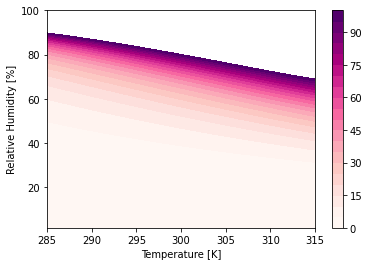

1.223746927743783


In [192]:
percent_error = np.abs(residual/LW_SC)
fig3, ax3 = plt.subplots()
#ax3.set_title('Energy difference between air and pure water vapor harvesting [  ]')
ax3.set_ylabel('Relative Humidity [%]')
ax3.set_xlabel('Temperature [K]')
ax3.set_xlim([285,315])
ax3.set_ylim([1.5,100])
length = np.linspace(0,100, 21)
cs = ax3.contourf(temp, 100*humd, 100*percent_error, length, vmin = 5, cmap="RdPu")
cbar = fig3.colorbar(cs)
plt.show()
fig3.savefig('percent_error.svg')
print(np.mean(percent_error))